# Credit Risk Default Prediction

Binary classification model to predict serious delinquency within 2 years.

**Target:** `SeriousDlqin2yrs`

---
## 1. Setup & Data Loading

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
import lightgbm as lgb

from sklearn.metrics import (
    roc_auc_score, average_precision_score, roc_curve, precision_recall_curve,
    confusion_matrix, classification_report,
    precision_score, recall_score, f1_score
)

import joblib
import os

plt.style.use('seaborn-v0_8-whitegrid')
print('Setup complete')

Setup complete


In [2]:
# Load data
DATA_PATH = '/Users/tomweinberg/Desktop/credit-risk-modeling/data/cs-training.csv'
MODEL_DIR = '/Users/tomweinberg/Desktop/credit-risk-modeling/models'
os.makedirs(MODEL_DIR, exist_ok=True)

df = pd.read_csv(DATA_PATH, index_col=0)
target = 'SeriousDlqin2yrs'

print(f'Dataset: {df.shape[0]:,} rows, {df.shape[1]} columns')
print(f'Default rate: {df[target].mean()*100:.2f}%')
print(f'\nMissing values:')
print(df.isnull().sum()[df.isnull().sum() > 0])

Dataset: 150,000 rows, 11 columns
Default rate: 6.68%

Missing values:
MonthlyIncome         29731
NumberOfDependents     3924
dtype: int64


---
## 2. Exploratory Data Analysis

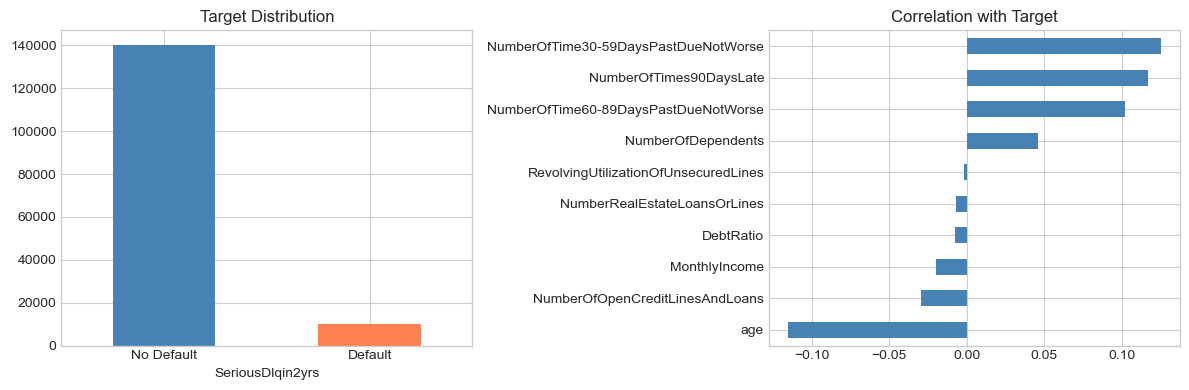

In [3]:
# Target distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

df[target].value_counts().plot(kind='bar', ax=axes[0], color=['steelblue', 'coral'])
axes[0].set_title('Target Distribution')
axes[0].set_xticklabels(['No Default', 'Default'], rotation=0)

# Correlation with target
corr = df.corr()[target].drop(target).sort_values()
corr.plot(kind='barh', ax=axes[1], color='steelblue')
axes[1].set_title('Correlation with Target')

plt.tight_layout()
plt.show()

---
## 3. Feature Engineering

In [4]:
def create_features(df):
    df = df.copy()
    
    # Fill missing values first
    df['MonthlyIncome'] = df['MonthlyIncome'].fillna(df['MonthlyIncome'].median())
    df['NumberOfDependents'] = df['NumberOfDependents'].fillna(0)
    
    # Cap outliers using IQR method
    for col in ['RevolvingUtilizationOfUnsecuredLines', 'DebtRatio', 'MonthlyIncome']:
        Q1, Q3 = df[col].quantile(0.25), df[col].quantile(0.75)
        IQR = Q3 - Q1
        df[col] = df[col].clip(Q1 - 1.5*IQR, Q3 + 1.5*IQR)
    
    # Delinquency severity score
    df['delinquency_score'] = (
        df['NumberOfTime30-59DaysPastDueNotWorse'] * 1 +
        df['NumberOfTime60-89DaysPastDueNotWorse'] * 2 +
        df['NumberOfTimes90DaysLate'] * 3
    )
    
    # Binary flags
    df['has_90_late'] = (df['NumberOfTimes90DaysLate'] > 0).astype(int)
    df['has_any_late'] = (df['delinquency_score'] > 0).astype(int)
    
    # Financial ratios
    df['income_per_dependent'] = df['MonthlyIncome'] / (df['NumberOfDependents'] + 1)
    df['debt_to_income'] = df['DebtRatio'] * df['MonthlyIncome']
    
    # Credit utilization flag
    df['high_utilization'] = (df['RevolvingUtilizationOfUnsecuredLines'] > 0.7).astype(int)
    
    # Age risk flag
    df['young_borrower'] = (df['age'] < 30).astype(int)
    
    # Fill any remaining NaN with 0
    df = df.fillna(0)
    
    return df

df_feat = create_features(df)
print(f'Features: {df_feat.shape[1]}')
print(f'Missing: {df_feat.isnull().sum().sum()}')

Features: 18
Missing: 0


---
## 4. Data Preparation

In [5]:
# Feature selection
feature_cols = [
    'RevolvingUtilizationOfUnsecuredLines', 'age', 'DebtRatio', 'MonthlyIncome',
    'NumberOfOpenCreditLinesAndLoans', 'NumberRealEstateLoansOrLines', 'NumberOfDependents',
    'delinquency_score', 'has_90_late', 'has_any_late',
    'income_per_dependent', 'debt_to_income', 'high_utilization', 'young_borrower'
]

X = df_feat[feature_cols]
y = df_feat[target]

# Stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Class weight for imbalanced data
pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

print(f'Train: {len(X_train):,}, Test: {len(X_test):,}')
print(f'Positive class weight: {pos_weight:.2f}')

Train: 120,000, Test: 30,000
Positive class weight: 13.96


---
## 5. Model Training & Comparison

In [6]:
# Store results
results = {}

# 1. Logistic Regression
print('Training Logistic Regression...')
lr = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
lr.fit(X_train_scaled, y_train)
results['Logistic'] = {
    'model': lr,
    'proba': lr.predict_proba(X_test_scaled)[:, 1]
}

# 2. Random Forest
print('Training Random Forest...')
rf = RandomForestClassifier(
    n_estimators=300, max_depth=8, min_samples_leaf=50,
    class_weight='balanced', random_state=42, n_jobs=-1
)
rf.fit(X_train_scaled, y_train)
results['RF'] = {
    'model': rf,
    'proba': rf.predict_proba(X_test_scaled)[:, 1]
}

# 3. XGBoost - tuned for PR-AUC
print('Training XGBoost...')
xgb = XGBClassifier(
    n_estimators=300, max_depth=5, learning_rate=0.05,
    scale_pos_weight=pos_weight, min_child_weight=50,
    subsample=0.8, colsample_bytree=0.8,
    random_state=42, n_jobs=-1, eval_metric='aucpr'
)
xgb.fit(X_train_scaled, y_train)
results['XGBoost'] = {
    'model': xgb,
    'proba': xgb.predict_proba(X_test_scaled)[:, 1]
}

# 4. LightGBM - tuned for PR-AUC
print('Training LightGBM...')
lgbm = lgb.LGBMClassifier(
    n_estimators=400, max_depth=6, num_leaves=40,
    learning_rate=0.03, scale_pos_weight=pos_weight,
    min_child_samples=50, subsample=0.8, colsample_bytree=0.8,
    reg_alpha=0.1, reg_lambda=1.0,
    random_state=42, verbose=-1, n_jobs=-1
)
lgbm.fit(X_train_scaled, y_train)
results['LightGBM'] = {
    'model': lgbm,
    'proba': lgbm.predict_proba(X_test_scaled)[:, 1]
}

print('Training complete!')

Training Logistic Regression...
Training Random Forest...
Training XGBoost...
Training LightGBM...
Training complete!


In [7]:
# Evaluate all models
print('='*70)
print('MODEL COMPARISON')
print('='*70)
print(f'{"Model":<12} {"ROC-AUC":>10} {"PR-AUC":>10} {"Precision":>10} {"Recall":>10}')
print('-'*70)

comparison_data = []
for name, res in results.items():
    proba = res['proba']
    pred = (proba >= 0.5).astype(int)
    
    roc = roc_auc_score(y_test, proba)
    pr = average_precision_score(y_test, proba)
    prec = precision_score(y_test, pred)
    rec = recall_score(y_test, pred)
    
    comparison_data.append({'Model': name, 'ROC-AUC': roc, 'PR-AUC': pr, 'Precision': prec, 'Recall': rec})
    print(f'{name:<12} {roc:>10.4f} {pr:>10.4f} {prec:>10.4f} {rec:>10.4f}')

comparison_df = pd.DataFrame(comparison_data)
best_model_name = comparison_df.loc[comparison_df['PR-AUC'].idxmax(), 'Model']
print(f'\nBest model by PR-AUC: {best_model_name}')

MODEL COMPARISON
Model           ROC-AUC     PR-AUC  Precision     Recall
----------------------------------------------------------------------
Logistic         0.8606     0.3609     0.2134     0.7566
RF               0.8661     0.3895     0.2207     0.7686
XGBoost          0.8682     0.4018     0.2231     0.7731
LightGBM         0.8685     0.4023     0.2259     0.7621

Best model by PR-AUC: LightGBM


---
## 6. Threshold Optimization for PR-AUC

In [8]:
# Use best model
best_proba = results[best_model_name]['proba']

# Find optimal threshold for F1
precision_curve, recall_curve, thresholds = precision_recall_curve(y_test, best_proba)
f1_scores = 2 * (precision_curve * recall_curve) / (precision_curve + recall_curve + 1e-8)
optimal_idx = np.argmax(f1_scores[:-1])
optimal_threshold = thresholds[optimal_idx]

print(f'Optimal threshold: {optimal_threshold:.3f}')
print(f'At this threshold:')
print(f'  Precision: {precision_curve[optimal_idx]:.4f}')
print(f'  Recall: {recall_curve[optimal_idx]:.4f}')
print(f'  F1: {f1_scores[optimal_idx]:.4f}')

# Compare thresholds
print('\nThreshold Analysis:')
print(f'{"Threshold":>10} {"Precision":>10} {"Recall":>10} {"F1":>10}')
print('-'*45)
for t in [0.2, 0.3, optimal_threshold, 0.5, 0.6]:
    pred = (best_proba >= t).astype(int)
    p = precision_score(y_test, pred)
    r = recall_score(y_test, pred)
    f = f1_score(y_test, pred)
    marker = ' <-- optimal' if abs(t - optimal_threshold) < 0.01 else ''
    print(f'{t:>10.3f} {p:>10.4f} {r:>10.4f} {f:>10.4f}{marker}')

Optimal threshold: 0.758
At this threshold:
  Precision: 0.3929
  Recall: 0.5317
  F1: 0.4519

Threshold Analysis:
 Threshold  Precision     Recall         F1
---------------------------------------------
     0.200     0.1225     0.9332     0.2166
     0.300     0.1528     0.8938     0.2610
     0.758     0.3929     0.5317     0.4519 <-- optimal
     0.500     0.2259     0.7621     0.3485
     0.600     0.2786     0.6773     0.3948


---
## 7. Final Model Evaluation

In [9]:
# Final predictions with optimal threshold
y_pred_final = (best_proba >= optimal_threshold).astype(int)

roc_auc = roc_auc_score(y_test, best_proba)
pr_auc = average_precision_score(y_test, best_proba)

print('='*60)
print(f'FINAL MODEL: {best_model_name}')
print('='*60)
print(f'\nROC-AUC: {roc_auc:.4f}')
print(f'PR-AUC:  {pr_auc:.4f}')
print(f'Gini:    {2*roc_auc - 1:.4f}')
print(f'\nUsing optimal threshold: {optimal_threshold:.3f}')
print()
print(classification_report(y_test, y_pred_final, target_names=['No Default', 'Default']))

FINAL MODEL: LightGBM

ROC-AUC: 0.8685
PR-AUC:  0.4023
Gini:    0.7371

Using optimal threshold: 0.758

              precision    recall  f1-score   support

  No Default       0.97      0.94      0.95     27995
     Default       0.39      0.53      0.45      2005

    accuracy                           0.91     30000
   macro avg       0.68      0.74      0.70     30000
weighted avg       0.93      0.91      0.92     30000



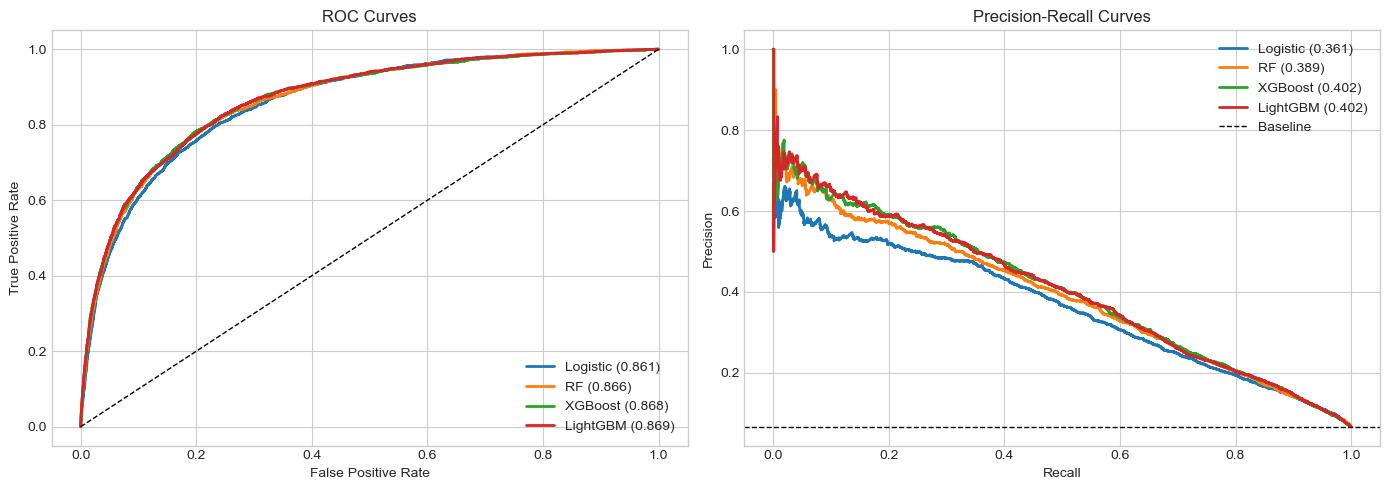

In [10]:
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC Curves
for name, res in results.items():
    fpr, tpr, _ = roc_curve(y_test, res['proba'])
    auc = roc_auc_score(y_test, res['proba'])
    axes[0].plot(fpr, tpr, lw=2, label=f'{name} ({auc:.3f})')
axes[0].plot([0,1], [0,1], 'k--', lw=1)
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curves')
axes[0].legend(loc='lower right')

# PR Curves
for name, res in results.items():
    prec, rec, _ = precision_recall_curve(y_test, res['proba'])
    ap = average_precision_score(y_test, res['proba'])
    axes[1].plot(rec, prec, lw=2, label=f'{name} ({ap:.3f})')
axes[1].axhline(y=y_test.mean(), color='k', linestyle='--', lw=1, label='Baseline')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curves')
axes[1].legend(loc='upper right')

plt.tight_layout()
plt.show()

---
## 8. Feature Importance

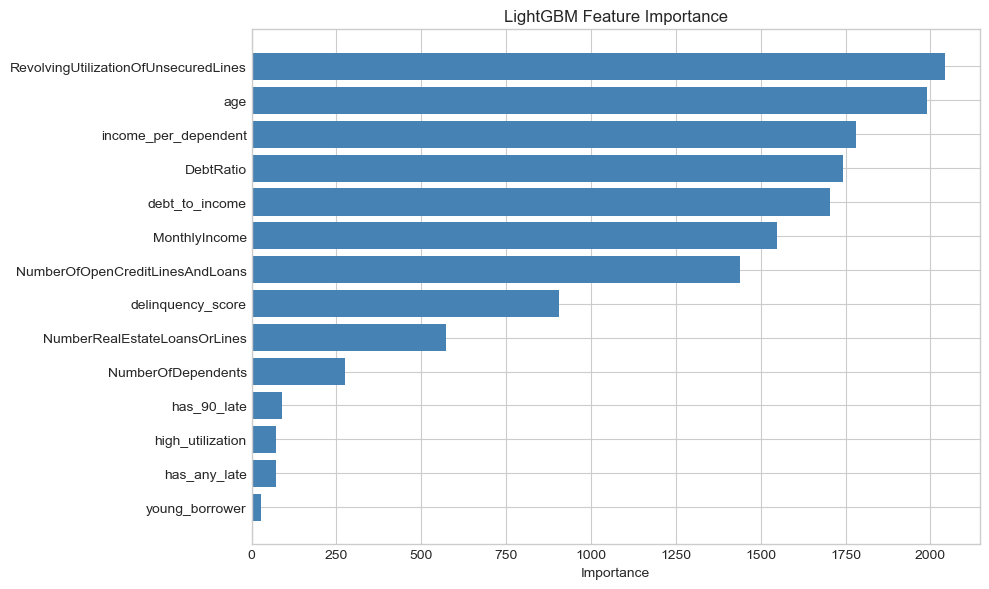

Top 5 features:
  RevolvingUtilizationOfUnsecuredLines: 2044.0000
  age: 1990.0000
  income_per_dependent: 1782.0000
  DebtRatio: 1744.0000
  debt_to_income: 1703.0000


In [11]:
# Feature importance from best model
if hasattr(results[best_model_name]['model'], 'feature_importances_'):
    importance = pd.DataFrame({
        'Feature': feature_cols,
        'Importance': results[best_model_name]['model'].feature_importances_
    }).sort_values('Importance', ascending=True)
    
    plt.figure(figsize=(10, 6))
    plt.barh(importance['Feature'], importance['Importance'], color='steelblue')
    plt.xlabel('Importance')
    plt.title(f'{best_model_name} Feature Importance')
    plt.tight_layout()
    plt.show()
    
    print('Top 5 features:')
    for _, row in importance.tail(5).iloc[::-1].iterrows():
        print(f"  {row['Feature']}: {row['Importance']:.4f}")

---
## 9. Save Model

In [12]:
# Save best model
model_path = os.path.join(MODEL_DIR, 'credit_risk_model.pkl')
joblib.dump({
    'model': results[best_model_name]['model'],
    'scaler': scaler,
    'features': feature_cols,
    'threshold': optimal_threshold
}, model_path)
print(f'Model saved: {model_path}')

Model saved: /Users/tomweinberg/Desktop/credit-risk-modeling/models/credit_risk_model.pkl


---
## Summary

In [13]:
print('='*60)
print('PROJECT SUMMARY')
print('='*60)
print(f'Dataset: {len(df):,} samples')
print(f'Features engineered: {len(feature_cols)}')
print(f'\nBest Model: {best_model_name}')
print(f'  ROC-AUC: {roc_auc:.4f}')
print(f'  PR-AUC:  {pr_auc:.4f}')
print(f'  Optimal threshold: {optimal_threshold:.3f}')

PROJECT SUMMARY
Dataset: 150,000 samples
Features engineered: 14

Best Model: LightGBM
  ROC-AUC: 0.8685
  PR-AUC:  0.4023
  Optimal threshold: 0.758
